In [14]:
# !pip install gensim
# !pip install tweet-preprocessor
# !pip install wordcloud

from keras import backend as K
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.layers import Dense, Input, LSTM, Embedding, Conv1D, Dropout, Activation, MaxPooling1D, concatenate, multiply, Lambda, TimeDistributed, Flatten, RepeatVector, Permute
from keras.layers import SpatialDropout1D
from keras.layers.normalization import BatchNormalization
from keras.models import Model, Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

## Load Data

In [2]:
train = pd.read_csv('cleaned_tweets.csv', index_col=0)

In [3]:
train.columns

Index(['Tweet', 'Target', 'Source', 'Cleaned', 'Cleaned_stop_words'], dtype='object')

In [4]:
sources_not_to_keep = ['dataset2_abhiraj', 'dataset3_abhiraj', 'dataset1_abhiraj']

print(train.shape)
train = train[train.Cleaned != 'None']
train = train[~train.Source.isin(sources_not_to_keep)]
train.dropna(axis = 0, inplace = True)
print(train.shape)

train= train.sample(frac=1).reset_index(drop=True)

train.Target.value_counts()

(28992, 5)
(16441, 5)


0.0    11139
1.0     5302
Name: Target, dtype: int64

In [39]:
X_train, X_test, y_train, y_test = train_test_split(train['Cleaned_stop_words'], train['Target'], test_size=0.20, random_state=42)

In [48]:
### Create sequence
vocabulary_size = 100000
tokenizer = Tokenizer(num_words= vocabulary_size)
tokenizer.fit_on_texts(train['Cleaned_stop_words'])
train_sequences = tokenizer.texts_to_sequences(X_train)
X_train_padded = pad_sequences(train_sequences, maxlen=140)

test_sequences = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(test_sequences, maxlen=140)

In [7]:
embeddings_index = dict()
f = open('glove.twitter.27B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [8]:
embedding_matrix = np.zeros((vocabulary_size, 100))
for word, index in tokenizer.word_index.items():
    if index > vocabulary_size - 1:
        break
    else:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector

## CNN + LSTM

In [20]:
## create model
lstm_cnn = Sequential()
lstm_cnn.add(Embedding(vocabulary_size, 100, input_length=140, weights=[embedding_matrix], trainable=False))
lstm_cnn.add(Dropout(0.2))
lstm_cnn.add(Conv1D(64, 5, activation='relu'))
lstm_cnn.add(MaxPooling1D(pool_size=4))
lstm_cnn.add(LSTM(100))
lstm_cnn.add(Dense(1, activation='sigmoid'))
lstm_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
## Fit train data
hist = lstm_cnn.fit(X_train_padded, y_train, validation_data = (X_test_padded, y_test), epochs = 7)

Train on 13152 samples, validate on 3289 samples
Epoch 1/7
13152/13152 [==============================] - 10s 783us/step - loss: 0.3704 - accuracy: 0.8276 - val_loss: 0.3175 - val_accuracy: 0.8559
Epoch 2/7
13152/13152 [==============================] - 10s 751us/step - loss: 0.3075 - accuracy: 0.8622 - val_loss: 0.3023 - val_accuracy: 0.8653
Epoch 3/7
13152/13152 [==============================] - 10s 746us/step - loss: 0.2785 - accuracy: 0.8734 - val_loss: 0.2891 - val_accuracy: 0.8720
Epoch 4/7
13152/13152 [==============================] - 10s 747us/step - loss: 0.2521 - accuracy: 0.8896 - val_loss: 0.2961 - val_accuracy: 0.8738
Epoch 5/7
13152/13152 [==============================] - 10s 751us/step - loss: 0.2244 - accuracy: 0.9018 - val_loss: 0.2942 - val_accuracy: 0.8723
Epoch 6/7
13152/13152 [==============================] - 10s 749us/step - loss: 0.1991 - accuracy: 0.9157 - val_loss: 0.3172 - val_accuracy: 0.8632
Epoch 7/7
13152/13152 [==============================] - 10s 75

In [51]:
y_pred = lstm_cnn.predict(X_test_padded,verbose=1)
preds  = np.round(y_pred.flatten())
accuracy_score(y_test, preds)
print(classification_report(y_test, preds, digits=3))

3289/3289 [==============================] - 1s 204us/step
              precision    recall  f1-score   support

         0.0      0.925     0.877     0.901      2210
         1.0      0.773     0.854     0.812      1079

    accuracy                          0.870      3289
   macro avg      0.849     0.866     0.856      3289
weighted avg      0.875     0.870     0.871      3289



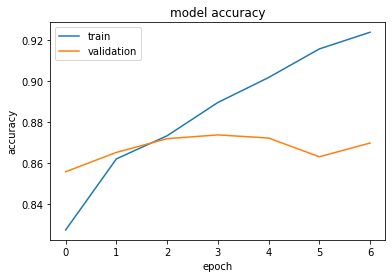

In [22]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

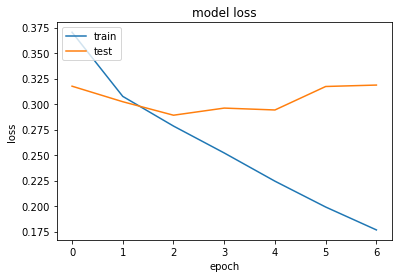

In [23]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## BiLSTM + MaxPool layer

In [28]:
inp = Input(shape=(140,))
x = Embedding(vocabulary_size, 100, weights=[embedding_matrix])(inp)
x = Bidirectional(LSTM(100, return_sequences=True, dropout=0.25, recurrent_dropout=0.1))(x)
x = GlobalMaxPool1D()(x)
x = Dense(100, activation="relu")(x)
x = Dropout(0.25)(x)
x = Dense(1, activation="sigmoid")(x)

In [29]:
bilstm = Model(inputs=inp, outputs=x)
bilstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [30]:
# model.fit(x_train, y_train, batch_size=16, epochs=10)
hist = bilstm.fit(X_train_padded, y_train, validation_data = (X_test_padded, y_test), epochs = 4)

/home/anmolshkl/anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 13152 samples, validate on 3289 samples
Epoch 1/4
13152/13152 [==============================] - 82s 6ms/step - loss: 0.3663 - accuracy: 0.8306 - val_loss: 0.3219 - val_accuracy: 0.8492
Epoch 2/4
13152/13152 [==============================] - 78s 6ms/step - loss: 0.2827 - accuracy: 0.8742 - val_loss: 0.2829 - val_accuracy: 0.8671
Epoch 3/4
13152/13152 [==============================] - 78s 6ms/step - loss: 0.2279 - accuracy: 0.9015 - val_loss: 0.2782 - val_accuracy: 0.8805
Epoch 4/4
13152/13152 [==============================] - 79s 6ms/step - loss: 0.1815 - accuracy: 0.9243 - val_loss: 0.3041 - val_accuracy: 0.8760


In [33]:
y_pred = bilstm.predict(X_test_padded,verbose=1)
preds  = np.round(y_pred.flatten())
accuracy_score(y_test, preds)
print(classification_report(y_test, preds, digits=3))

3289/3289 [==============================] - 2s 707us/step
              precision    recall  f1-score   support

         0.0      0.918     0.896     0.907      2210
         1.0      0.797     0.835     0.815      1079

    accuracy                          0.876      3289
   macro avg      0.857     0.865     0.861      3289
weighted avg      0.878     0.876     0.877      3289



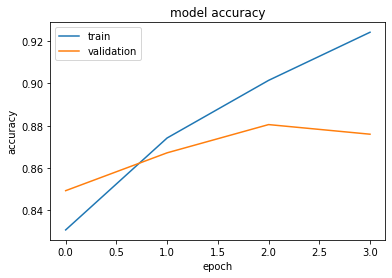

In [34]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

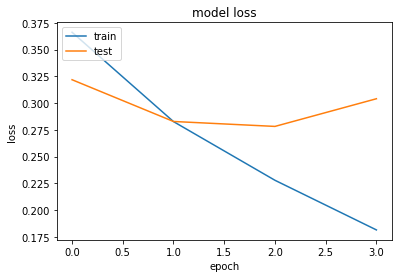

In [35]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

  ## BiLSTM with Attention

In [36]:
lstm_units = 128

in_text = Input(shape=(140, ))
embedding_layer = Embedding(vocabulary_size,
                        100,
                        weights=[embedding_matrix],
                        input_length=140,
                        trainable=False)
x = embedded_sequences = embedding_layer(in_text)
bilstm = Bidirectional(LSTM(lstm_units,return_sequences=True, dropout=0.3, recurrent_dropout=0.25))(x)  
attention = TimeDistributed(Dense(1,activation='tanh'))(bilstm)
attention = Flatten()(attention)
attention = Activation('softmax')(attention)
attention = RepeatVector(2*lstm_units)(attention)
attention = Permute([2, 1])(attention)
sent_representation = multiply([bilstm, attention])
out_text = Lambda(lambda xin: K.sum(xin, axis= 1), output_shape=(2*lstm_units,), name='sent')(sent_representation) 

output_ = Dense(1, activation='sigmoid')(out_text) 

bilstm_attn = Model(inputs=in_text, outputs= output_) 
bilstm_attn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [37]:
history = bilstm_attn.fit(X_train_padded, y_train, validation_data = (X_test_padded, y_test), epochs=10)

Train on 13152 samples, validate on 3289 samples
Epoch 1/10
13152/13152 [==============================] - 28s 2ms/step - loss: 0.4117 - accuracy: 0.8049 - val_loss: 0.3492 - val_accuracy: 0.8364
Epoch 2/10
13152/13152 [==============================] - 27s 2ms/step - loss: 0.3477 - accuracy: 0.8406 - val_loss: 0.3225 - val_accuracy: 0.8562
Epoch 3/10
13152/13152 [==============================] - 27s 2ms/step - loss: 0.3291 - accuracy: 0.8514 - val_loss: 0.3108 - val_accuracy: 0.8647
Epoch 4/10
13152/13152 [==============================] - 27s 2ms/step - loss: 0.3137 - accuracy: 0.8598 - val_loss: 0.3045 - val_accuracy: 0.8650
Epoch 5/10
13152/13152 [==============================] - 27s 2ms/step - loss: 0.3041 - accuracy: 0.8637 - val_loss: 0.2950 - val_accuracy: 0.8708
Epoch 6/10
13152/13152 [==============================] - 27s 2ms/step - loss: 0.2945 - accuracy: 0.8712 - val_loss: 0.2928 - val_accuracy: 0.8723
Epoch 7/10
13152/13152 [==============================] - 27s 2ms/ste

In [53]:
y_pred = bilstm_attn.predict(X_test_padded,verbose=1)
preds  = np.round(y_pred.flatten())
accuracy_score(y_test, preds)
print(classification_report(y_test, preds, digits=3))

3289/3289 [==============================] - 2s 545us/step
              precision    recall  f1-score   support

         0.0      0.907     0.914     0.910      2210
         1.0      0.820     0.807     0.814      1079

    accuracy                          0.879      3289
   macro avg      0.863     0.860     0.862      3289
weighted avg      0.878     0.879     0.878      3289



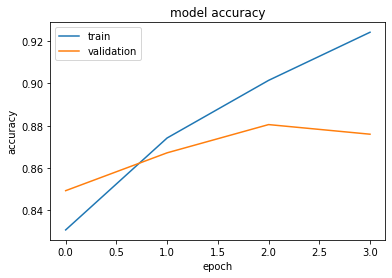

In [73]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

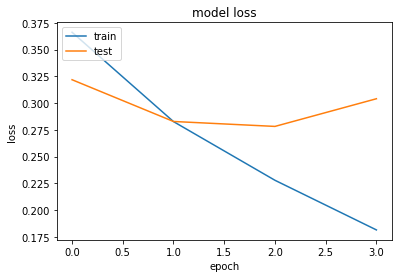

In [74]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Finding the mismatch between simple LSTM and BiLSTM with Attention

In [50]:
np.flatnonzero(y_test != preds)

array([   6,    7,   22,   31,   47,   54,   59,   69,   81,   86,   94,
        121,  123,  132,  133,  135,  159,  170,  176,  189,  196,  219,
        230,  235,  241,  246,  249,  256,  277,  300,  303,  307,  311,
        316,  325,  332,  347,  350,  360,  361,  367,  377,  379,  382,
        394,  395,  413,  426,  427,  444,  456,  486,  492,  493,  495,
        510,  512,  523,  527,  530,  539,  546,  549,  553,  573,  595,
        606,  619,  633,  643,  646,  648,  655,  662,  665,  668,  670,
        675,  694,  695,  698,  707,  713,  727,  730,  742,  767,  769,
        777,  804,  805,  827,  853,  857,  865,  869,  870,  874,  887,
        901,  903,  911,  913,  917,  928,  950,  951,  953,  957,  970,
        976,  986,  993,  994, 1002, 1008, 1012, 1024, 1032, 1046, 1048,
       1057, 1061, 1063, 1066, 1070, 1076, 1094, 1102, 1108, 1109, 1119,
       1124, 1131, 1132, 1136, 1137, 1146, 1158, 1169, 1172, 1179, 1180,
       1190, 1207, 1214, 1216, 1229, 1237, 1255, 12

In [52]:
lstm_incorrect = np.flatnonzero(y_test != preds)

In [54]:
attn_incorrect = np.flatnonzero(y_test != preds)

In [57]:
index = np.setdiff1d(lstm_incorrect, attn_incorrect)

### Examples that BiLSTM + attention got right but LSTM + CNN got wrong

Please see the report for detailed analysis.

In [69]:
X_test.reset_index(drop=True)[index]

0                            My GrandMa making Dinenr Mum
5       Go four Dos four Don ts take long way depressi...
8       would someone write movie like The Fault Our S...
15                                            another one
73      saw two really cute weenie dogs walking togeth...
93      No job No car No money No worth That kinda I r...
102     You Already Whole Some Thoughts How We Talk Ab...
108     sadly deep thought But I think It farely diffi...
136     Re problems continue perplex us Say There silv...
141                                         For suffering
147     You hold every moment calm raging seas walk fi...
152     I got cuddles besitos I wanted yet ass still s...
164                           If unfamiliar ACT take look
236     Why leave Park Bom alone Instead reporting imp...
301              laying bed 2 sleep blast one I love 2day
323                Are stuck cycle We exist help break RT
330     One common misunderstandings depression simila...
353     Even G

### Examples where both LSTM+CNN and BiLSTM + Attention got wrong

In [71]:
same_index = np.intersect1d(lstm_incorrect, attn_incorrect)

In [72]:
X_test.reset_index(drop=True)[same_index]

6       ppl parents immature enough understand depress...
7       Love gon na watch 24 7 social life newt depres...
31                        I pretty sure called depression
47      deserve nobel peace prize punching bitch face ...
69                                           Please alone
81                                   Why today everywhere
86      I watch lunch anymore I laughing way much acce...
94      She definitely showed signs alcoholism potenti...
121               feeling unwanted terrible Mother Teresa
123     When students choose college academically chal...
132                 Depression A Struggle Made Easier CBD
135       Third Eye Blind long drive home Oh I get enough
159                                                  None
189                        Go harder everyone else enough
196                                                  None
219     depression basically nonexistent days clear fi...
230     My 2c fellow redditors high functioning depres...
241     Where 